# 滑面识别程序 / Sliding surface identification program

## 0 一些准备工作 / Some preparation work

### 0.1 导入相关库 / Import related libraries
导入一些运行所必须的库 / Import some necessary libraries for operation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.metrics as sm
from skimage import io, measure, morphology
from sklearn.cluster import KMeans, MiniBatchKMeans
import copy
from PIL import Image, ImageChops
import time

import alphashape

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import metrics
from sklearn.cluster import DBSCAN

import shapely.geometry


### 0.2 设置相关参数 / Set the relevant parameters

其中的 A, B, C, D, E, F 坐标如图所示，使用的是像素坐标，可用画图等软件获取该坐标。

The coordinates of A, B, C, D, E and F are shown in the figure. The pixel coordinates are used, and the coordinates can be obtained by software such as *Microsoft Paint*.

![alt text](坐标.svg)

In [18]:
# 总位移云图所在目录 / The directory of the total displkacement contour map
image_path = "program_process_files"

# A_x, A_y = 600, 1687
# B_x, B_y = 3262, 1687
# C_x, C_y = 3262, 90
# D_x, D_y = 2197, 90
# E_x, E_y = 865, 1421
# F_x, F_y = 600, 1421

p_A = [  63, 635]
p_B = [1470, 635]
p_C = [1470, 196]
p_D = [1106, 196]
p_E = [ 570, 465]
p_F = [  63, 465]



slope_boundary_array = [p_A, p_B, p_C, p_D, p_E, p_F]

# 保存的颜色为类似红色,其意义为只保存最接近该种颜色的颜色
# The color preserved is similar to red, which means that only the color closest to the color is preserved.
keep_of_color = np.array([0, 0, 0]) / 255.0
# 其他颜色直接设置other_color
# Other colors set other_color directly.
other_color = np.array([255, 255, 255]) / 255.0


# 像素尺寸与实际尺寸比例 / The ratio of pixel size to actual size
k = 21.93548


## 1 滑块识别 / Sliding surface identification

### 1.1 使用图像分割识别包含其他块体的滑块 / Image segmentation is used to identify sliding block containing other blocks

In [3]:
# 定义函数用于识别包含其他块体的滑块
# A function is defined to identify the sliding block containing other blocks.
def get_block_with_noise(imgae_path, str_of_picture):
    filename_of_image = image_path + "\\" + "Slice_slide_" + str_of_picture + ".png"

    num_of_color = 2
    color_of_keep = np.array([0, 0, 0]) / 255.0
    other_color = np.array([255, 255, 255]) / 255.0

    # 读取图片并显示
    image = io.imread(filename_of_image)

    # 读取图片每个像素点的信息(RGB值)
    data = image / 255.0
    # print("pre_data: \n", data)
    data = data.reshape(-1, 3)
    # print("lat_data: \n", data)

    # 开始对图片中的像素进行聚类
    # 最要想要留下的颜色个数
    color_use = num_of_color
    # 开始进行聚类
    # km = MiniBatchKMeans(color_use)
    km = KMeans(init='k-means++', n_clusters=color_use, random_state=0)
    km.fit(data)
    # 利用np.array的整数索引，用聚类中心点值，代替原来点的值
    new_data = km.cluster_centers_[km.predict(data)]
    # 获取查看剩下的color_use 种颜色
    # print("new_data: \n", new_data)
    color_set = np.array(list(set([tuple(t) for t in new_data])))
    # print("color_set:\n", color_set)

    # 计算聚类后的每种颜色与保留色的距离
    dist = []
    for i in range(len(color_set)):
        dist.append(np.sqrt(np.sum(np.square(color_set[i] - color_of_keep))))

    # print("dist:\n", dist)

    # 获取距离最小的下标
    index_min = dist.index(min(dist))
    # print("index_min: ", index_min)

    # 将new_data中除最小下标所对应的值之外的值变为指定颜色
    for i in range(len(new_data)):
        if tuple(new_data[i]) != tuple(color_set[index_min]):
            new_data[i] = other_color
        else:
            # new_data[i] = np.array([0, 0, 0])
            new_data[i] = color_of_keep

    # 重新设置图片
    image_new = new_data.reshape(image.shape)
    image_new_convert = np.array(np.round(image_new * 255), dtype='uint8')
    save_name_of_image = image_path + "\\cluster_image_" + str_of_picture + ".jpg"
    io.imsave(save_name_of_image, image_new_convert)


In [9]:
# 函数“get_block_with_noise”检查，可不运行 \ Code for checking the function 'get_block_with_noise', you can not run
get_block_with_noise(image_path, "47.50")

### 1.2 使用连通区域标识面积去除其他块体 \ Use connected domain identification to remove other blocks

In [4]:
# 定义一个函数，去除多余滑块
# Define a function to remove redundant sliding blocks
def remove_noise_block(image_path, str_of_picture):
    save_name_of_image = image_path + "\\cluster_image_" + str_of_picture + ".jpg"
    # 使用cv2读取图片
    image = cv2.imread(save_name_of_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opening = 255 - \
        cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    
    save_name_of_image = image_path + "\\cluster_image_without_noise_" + str_of_picture + ".jpg"

    io.imsave(save_name_of_image, opening)

    # 再将图片反色 #
    im = Image.open(save_name_of_image)
    im_inverted = ImageChops.invert(im)
    im_inverted.save(save_name_of_image)

    # 对输入图像进行降噪，去除噪声干扰，然后再二值化 #
    # ----------- 第一个调试点, 用于出图 -----------# 出 反色之后的图
    im = cv2.imread(save_name_of_image)
    # print(im)
    blurred = cv2.GaussianBlur(im, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    t, binary = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # 将数组还原成图片 Image.fromarray方法 传入数组 和 通道
    img = Image.fromarray(binary)
    img.save(save_name_of_image)

    # 使用连通域阈值对图片进行去噪 #
    threshold = 35000  # ----------- 第二个调试点, 用于出图 -----------#
    # 读入图片
    img = cv2.imread(save_name_of_image, cv2.IMREAD_COLOR)
    GrayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 图片灰度化处理
    # 二值化图片
    ret, binary = cv2.threshold(GrayImage, 40, 255, cv2.THRESH_BINARY)
    # cv2.fingContours寻找图片轮廓信息
    """
    提取二值化后图片中的轮廓信息 ，返回值contours存储的即是图片中的轮廓信息，是一个向量，内每个元素保存了一组由连续的Point点构成的点的集合的向量，每一组Point点集就是一个轮廓，有多少轮廓，向量contours就有多少元素
    """
    contours, hierarch = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) == 1:
        pass
    else:
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])  # 计算轮廓所占面积
            if area < threshold:  # 将area小于阈值区域填充背景色，由于OpenCV读出的是BGR值
                # 原始图片背景BGR值(84,1,68)
                cv2.drawContours(img, [contours[i]], -1, (0, 0, 0), thickness=-1)
                continue

    # cv2.imshow('Output',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 保存图片
    cv2.imwrite(save_name_of_image, img)

    # 在执行一次反色
    im = Image.open(save_name_of_image)
    im_inverted = ImageChops.invert(im)

    im_inverted.save(save_name_of_image)


In [11]:
# 函数“remove_noise_block”检查，可不运行 \ Code for checking the function 'remove_noise_block', you can not run
remove_noise_block(image_path, "47.50")

## 2 滑面识别 \ Sliding surface identification

### 2.1 识别滑块边界 \ Identify the slider boundary

#### 2.1.1 使用alpha shapes算法获取滑块边界 \ Use the alpha shapes algorithm to obtain the sliding block boundary

In [5]:
def get_black_point(image_file):
    # 打开图片文件
    img = Image.open(image_file).convert("RGB")
    array_of_image = np.asarray(img)
    black_point_array = []
    # print(array_of_image[0][0][0])

    for i in range(len(array_of_image)):
        for j in range(len(array_of_image[0])):
            if array_of_image[i][j][0] < 128:
                temp_point = [j, i]
                black_point_array.append(temp_point)
    # print(black_point_array[0])

    alpha_shape = alphashape.alphashape(black_point_array, 0.5)
    # print(alpha_shape)

    boundary_array = alpha_shape.exterior.coords[:]
    # print(shape(boundary_array))

    return boundary_array

### 2.2 去除滑块边界中边坡面部分 \ Remove the slope boundary in the slider boundary

In [6]:
# # 这是原来使用的方法，现在不再使用该方法
# # This was the original method, which is no longer used
# # 2. 利用边坡边界的线段方程，去除大部分边坡边界
# # 2. Most of the slope boundaries are removed by using the line segment equation of the slope boundary
# def get_init_slide(boundary_array):
#     # print("boundary_array len is", len(boundary_array))
#     slide_array = []
#     for i in range(len(boundary_array)):
#         k = (D_y - E_y) / (D_x - E_x)
#         b = E_y - k * E_x
#         x = boundary_array[i][0]
#         y = boundary_array[i][1]
#         error_range = 6
#         if (y - error_range) <= (k * x + b) <= (y + error_range):
#             # print("({:4.1f}, {:4.1f})".format(x, y))
#             continue
#         if y - 1 <= D_y <= y + 1:
#             # print("({:4.1f}, {:4.1f})".format(x, y))
#             continue
#         if (F_x <= x <= E_x) and (y - 1 <= F_y <= y + 1):
#             continue

#         slide_array.append(boundary_array[i])
#     return slide_array


In [7]:
# 2_. 定义一个去除边界的新函数 / Define a new function to remove the boundary
# 2_1. 判断一个点是否在多边形内 / To determine whether a point is in a polygon
def judge_point_in_polygon(point_, polygon_array_):
    point_func = shapely.geometry.Point(point_)

    poly_context = {"type": "MULTIPOLYGON",
                    "coordinates": [[polygon_array_]]}
    poly_shape = shapely.geometry.shape(poly_context)
    return poly_shape.intersects(point_func)

# 2_2. 判断一系列点是否在多边形内 / Determines whether a series of points are within a polygon
def judge_points_in_polygon(point_array_, polygon_array_):
    print("slope_before:", polygon_array_)
    # 由于不能包含边界上的点，所以将非0的边界点减去6
    for i in range(len(polygon_array_)):
        if polygon_array_[i][0] != 0:
            polygon_array_[i][0] += 1
        if polygon_array_[i][1] != 0:
            polygon_array_[i][1] += 1

    print("slope_after:", polygon_array_)
    judge_in_polygon = np.array([False] * len(point_array_))
    # print(point_array_)
    for i in range(len(point_array_)):
        # print(i)
        judge_in_polygon[i] = judge_point_in_polygon(point_array_[i], polygon_array_)
    # print(judge_in_polygon)
    return judge_in_polygon

# 2_3. 获取只在多边形内的点 / Get the points only in the polygon
def get_in_points(point_array_, polygon_array_):
    # print(point_array_)
    judge_in_polygon = judge_points_in_polygon(point_array_, polygon_array_)
    # print(judge_in_polygon)
    points_in_polygon_ = []
    for i in range(len(judge_in_polygon)):
        if judge_in_polygon[i]:
            points_in_polygon_.append(point_array_[i])

    return np.array(points_in_polygon_)

In [8]:
# 3. 定义去除滑面噪点的函数
# Define the function to remove the noise of the sliding surface
def remove_noise_form_silde(slide_array):
    # 定义dbscan函数
    def dbscan_(data, r, min_samples):
        """实现DBSCAN算法

        Args:
            data (ndarray): 输入数据集
            r (float): 阈值半径
            min_samples (int): 点数阈值
        """
        db = DBSCAN(eps=r, min_samples=min_samples)
        data = data.reshape(-1, 1)
        clustering = db.fit(data)
        # 计算分簇
        labels = clustering.labels_.tolist()
        # # 计算分簇数
        # if -1 in labels:
        #     k = len(set(labels)) - 1
        # else:
        #     k = len(set(labels))
        # # 计算轮廓系数
        # if k == 0:
        #     dbscan_score = 0
        # else:
        #     dbscan_score = metrics.silhouette_score(X=data, labels=labels)

        return labels
    result = dbscan_(slide_array, 10, 10)
    # print(result[0])

    slide_label = result
    print("set slide is ", set(slide_label))
    label_sum = [0 for i in range(len(set(slide_label)) - 1)]
    slide_array_db = []
    # # 获取除噪点之外最短的一组
    # for i_ in range(len(slide_array)):
    #     if slide_label[i_] == -1:
    #         continue
    #     label_sum[slide_label[i_]] += 1
    
    # min_num_of_label = min(label_sum)
    # index_min_label = label_sum.index(min_num_of_label)

    for i_ in range(len(slide_array)):        
        if slide_label[i_] == -1: # or slide_array[i_] == index_min_label:
            continue
        slide_array_db.append(slide_array[i_])
    print("num_of_labels is ", label_sum)
    return slide_array_db


In [9]:
# 4. 对数组进行重新排序
# Reorder an array
def resort_slide(slide_array_w_noise):
    silde_left = []
    slide_right = []

    label = 1
    for i in range(1, len(slide_array_w_noise)):
        d = abs(slide_array_w_noise[i][1] - slide_array_w_noise[i - 1][1])
        if d >= 100:
            # print("ge")
            label = 0

        # print(label)
        if label == 0:
            silde_left.append(slide_array_w_noise[i])
        elif label == 1:
            slide_right.append(slide_array_w_noise[i])

    slide_array_resort = silde_left + slide_right

    slide_array = []

    return slide_array_resort


### 2.3 定义函数，获取滑动面 \ Define the function to obtain the sliding surface

In [10]:
# 定义一个函数，获取单张图片的滑动面
# Define a function to obtain the sliding surface of a single picture
def get_curve_of_slide(image_path, str_of_picture):
    image_file = image_path + "\\cluster_image_without_noise_" + str_of_picture + ".jpg"
    boundary_array = get_black_point(image_file=image_file)
    # print(boundary_array)
    # slide_array = get_init_slide(boundary_array=boundary_array)
    slide_array = get_in_points(boundary_array, slope_boundary_array)
    print(len(slide_array))
    slide_array_w_noise = remove_noise_form_silde(slide_array=slide_array)
    slide_array_resort = resort_slide(slide_array_w_noise=slide_array_w_noise)
    x_of_slide = []
    y_of_slide = []
    for i_ in slide_array_resort:
        x_of_slide.append(i_[0])
        y_of_slide.append(i_[1])
    return x_of_slide, y_of_slide


In [11]:
# 定义一个保存x,y的函数
def get_and_save_x_y_array(image_path, str_of_picture, float_of_picture):
    x_i_, y_i_ = get_curve_of_slide(image_path, str_of_picture)
    x_i_array = np.array(x_i_)
    y_i_array = np.array(y_i_)
    z_i_array = np.array([float_of_picture * k for i in range(len(x_i_))])
    np.savetxt(image_path + "\\x_array_" + str_of_picture + ".txt", x_i_array, fmt="%4d")
    np.savetxt(image_path + "\\y_array_" + str_of_picture + ".txt", y_i_array, fmt="%4d")
    np.savetxt(image_path + "\\z_array_" + str_of_picture + ".txt", z_i_array, fmt="%4.5f")
    return x_i_, y_i_

In [19]:
# 函数“get_and_save_x_y_array”检查，可不运行 \ Code for checking the function 'get_and_save_x_y_array', you can not run
x_i, y_i = get_and_save_x_y_array(image_path, "47.50", 47.5)

slope_before: [[63, 635], [1470, 635], [1470, 196], [1106, 196], [570, 465], [63, 465]]
slope_after: [[64, 636], [1471, 636], [1471, 197], [1107, 197], [571, 466], [64, 466]]
175
set slide is  {0, 1}
num_of_labels is  [0]


## 3 绘制滑动面 \ Draw the sliding surface
### 3.1 绘制单独的滑动面 \ Draw single sliding surface
> 未运行上一个单元格无法绘图 \ Unable to draw without running the previous cell

NameError: name 'y_i' is not defined

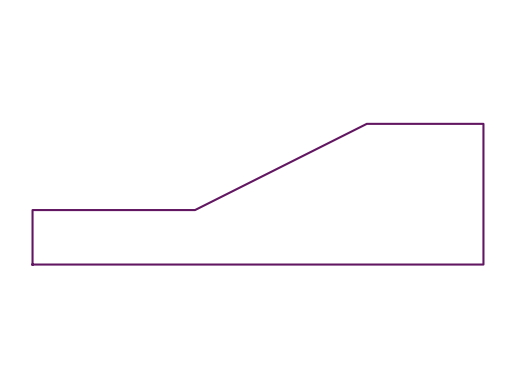

In [12]:
plt.axis('off')
plt.axis("equal")
# plt.xlim(-10, 2732)
# plt.ylim(-10, 1677)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
fig = plt.gcf()

slope_x_array = np.array([])
slope_y_array = np.array([])

for i in range(len(slope_boundary_array)):
    slope_x_array = np.append(slope_x_array, slope_boundary_array[i][0])
    slope_y_array = np.append(slope_y_array, slope_boundary_array[i][1])
slope_x_array = np.append(slope_x_array, slope_boundary_array[0][0])
slope_y_array = np.append(slope_y_array, slope_boundary_array[0][1])

max_y = max(slope_y_array)
slope_y_array = max_y - slope_y_array

# max_y = max(A_y, B_y, C_y, D_y, E_y, F_y)
# A_y_, B_y_, C_y_, D_y_, E_y_, F_y_ = max_y - A_y, max_y - B_y, max_y - C_y, max_y - D_y, max_y - E_y, max_y - F_y

# plt.plot((A_x, B_x, C_x, D_x, E_x, F_x, A_x), (A_y_, B_y_, C_y_,
#                                                D_y_, E_y_, F_y_, A_y_), linewidth=1.5, color="#621661", zorder=2)

plt.plot(slope_x_array, slope_y_array, linewidth=1.5, color="#621661", zorder=2)

y_i_ = []
for i in y_i:
    y_i_.append(max_y - i)
plt.plot(x_i, y_i_, linewidth=1, zorder=1)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.margins(0, 0)
fig.savefig(image_path + "\\slide_surface.pdf",
            format='pdf', dpi=1200, pad_inches=0, transparent=1)
plt.show()


### 3.2 将滑动面与总位移云图、最大剪切应变云图分别绘制 \ Draw the sliding surface with the total displacement contour map and the maximum shear strain contour map respectively

> 用于批量识别时，不执行这里的代码，即是不绘制滑动面-最大剪切应变云图和滑动面-总位移云图
>
> When used for batch identification, the code here is not executed, that is, the Sliding surface-maximum shear strain contour map and the Sliding surface-total displacement contour map are not drawn.

#### 3.2.1 滑动面-最大剪切应变云图 \ Sliding surface-maximum shear strain contour map

In [21]:
# maximum_shear_strain_image = image_path + "\\maximum_shear_strain.jpg"
# # 为了避免每次都要重新运行上面的代码，这里选择从文件中读取x, y的数据
# x_i = np.loadtxt(image_path + "\\x_array.txt", dtype=float)
# y_i = np.loadtxt(image_path + "\\y_array.txt", dtype=float)

# img = Image.open(maximum_shear_strain_image)
# plt.figure("Image", figsize=(19.16, 8.65))  # 图像窗口名称
# plt.imshow(img)
# plt.plot(x_i, y_i, linewidth=3, color="red")
# plt.savefig(image_path + "\\mss_slide.pdf",
#             format='pdf', dpi=1200, pad_inches=0)


#### 3.2.2 滑动面-总位移云图 \ Sliding surface-total displacement contour map

In [22]:
# total_displacement_image = image_path + "\\total_displacement_.jpg"
# img = Image.open(total_displacement_image)
# plt.figure("Image", figsize=(19.16, 8.65))  # 图像窗口名称
# plt.imshow(img)
# plt.plot(x_i, y_i, linewidth=3, color="red")
# plt.savefig(image_path + "\\td_silde.pdf",
#             format='pdf', dpi=1200, pad_inches=0)


## 4 循环识别每个图的滑面 \ Circularly identify the sliding surface of each graph

### 4.1 必要的一些参数 \ Some necessary parameters

In [13]:
# 进行批量识别的一些必要参数 \ Some necessary parameters for batch identification
# 除了前缀之外和后缀之外的文件名 \ File names other than prefixes and suffixes
# 下面为z坐标为区分 \ The following is the z coordinate for the distinction
z_str_of_current_in = np.array(["02.50", "05.00", "10.00", "15.00", "20.00", "25.00", "30.00", "35.00", "40.00", "45.00", "47.50"])
# 获取浮点型的z坐标 \ Obtain the z coordinate of the float type
z_float_of_current_in = np.array([float(str_i) for str_i in z_str_of_current_in])
# z_float_of_current_in
# 像素尺寸与实际尺寸比例 / The ratio of pixel size to actual size
k = 21.93548
# x,y 在实际尺寸中的相对坐标 / The relative coordinates of x, y in the actual size
x = 2.85799
y = 8.94853

### 4.2 循环获取每个截面的滑面 \ The sliding surface of each section is obtained circularly
> 我不能理解为什么循环到最后一个("47.50")程序会报错，如果发生报错的请单独运行下下个单元格。
>
> I can't understand why the loop to the last ("47.50") program will report an error. If an error occurs, please run the next cell of the next.

In [16]:
for i in range(len(z_str_of_current_in)):
    # 1.1 获取所有块体
    get_block_with_noise(image_path, z_str_of_current_in[i])
    # 1.2 使用连通域去除其他块体
    remove_noise_block(image_path, z_str_of_current_in[i])
    # 2. 获取滑动面
    get_and_save_x_y_array(image_path, z_str_of_current_in[i], z_float_of_current_in[i])

slope_before: [[63, 635], [1470, 635], [1470, 196], [1106, 196], [570, 465], [63, 465]]
slope_after: [[64, 636], [1471, 636], [1471, 197], [1107, 197], [571, 466], [64, 466]]
175
set slide is  {0, 1}
num_of_labels is  [0]
slope_before: [[64, 636], [1471, 636], [1471, 197], [1107, 197], [571, 466], [64, 466]]
slope_after: [[65, 637], [1472, 637], [1472, 198], [1108, 198], [572, 467], [65, 467]]
371
set slide is  {0, 1}
num_of_labels is  [0]
slope_before: [[65, 637], [1472, 637], [1472, 198], [1108, 198], [572, 467], [65, 467]]
slope_after: [[66, 638], [1473, 638], [1473, 199], [1109, 199], [573, 468], [66, 468]]
468
set slide is  {0, 1}
num_of_labels is  [0]
slope_before: [[66, 638], [1473, 638], [1473, 199], [1109, 199], [573, 468], [66, 468]]
slope_after: [[67, 639], [1474, 639], [1474, 200], [1110, 200], [574, 469], [67, 469]]
504
set slide is  {0, 1}
num_of_labels is  [0]
slope_before: [[67, 639], [1474, 639], [1474, 200], [1110, 200], [574, 469], [67, 469]]
slope_after: [[68, 640],

In [13]:
# 如果上一个单元格没有报错，则没有必要运行这个单元格 / If there is no error in the previous cell, there is no need to run this cell
print(z_str_of_current_in[-1])
print(z_float_of_current_in[-1])
# 1.1 获取所有块体
get_block_with_noise(image_path, z_str_of_current_in[-1])
# 1.2 使用连通域去除其他块体
remove_noise_block(image_path, z_str_of_current_in[-1])
# 2. 获取滑动面
get_and_save_x_y_array(image_path, z_str_of_current_in[-1], z_float_of_current_in[-1])

47.50
47.5
slope_before: [[63, 635], [1470, 635], [1470, 196], [1106, 196], [570, 465], [63, 465]]
slope_after: [[65, 637], [1472, 637], [1472, 198], [1108, 198], [572, 467], [65, 467]]
172
set slide is  {0, 1}
num_of_labels is  [0]


([676.0,
  677.0,
  678.0,
  679.0,
  680.0,
  682.0,
  683.0,
  684.0,
  685.0,
  686.0,
  688.0,
  689.0,
  690.0,
  692.0,
  693.0,
  694.0,
  695.0,
  697.0,
  698.0,
  699.0,
  701.0,
  702.0,
  703.0,
  705.0,
  706.0,
  707.0,
  709.0,
  710.0,
  711.0,
  713.0,
  714.0,
  715.0,
  717.0,
  718.0,
  719.0,
  721.0,
  722.0,
  723.0,
  725.0,
  726.0,
  727.0,
  729.0,
  730.0,
  732.0,
  733.0,
  734.0,
  736.0,
  737.0,
  739.0,
  740.0,
  741.0,
  743.0,
  744.0,
  746.0,
  747.0,
  749.0,
  750.0,
  752.0,
  753.0,
  755.0,
  756.0,
  758.0,
  759.0,
  761.0,
  762.0,
  764.0,
  765.0,
  767.0,
  768.0,
  770.0,
  771.0,
  773.0,
  775.0,
  776.0,
  778.0,
  779.0,
  781.0,
  783.0,
  784.0,
  786.0,
  787.0,
  789.0,
  791.0,
  793.0,
  794.0,
  796.0,
  798.0,
  800.0,
  801.0,
  803.0,
  805.0,
  807.0,
  808.0,
  810.0,
  812.0,
  814.0,
  816.0,
  817.0,
  819.0,
  821.0,
  823.0,
  825.0,
  826.0,
  828.0,
  830.0,
  832.0,
  834.0,
  836.0,
  838.0,
  840.0,
  842.0,
 

### 4.3 绘制3D图 \ Draw a 3D drawing
> 这部分为了在使用其他IDE(PyCharm等)也能绘制，因此会重复写一下上面已经出现的变量及导入已导入过的库。
> 
> In order to be able to draw in other IDEs (PyCharm, etc.), this part will repeat the variables that have appeared above and import the libraries that have been imported.

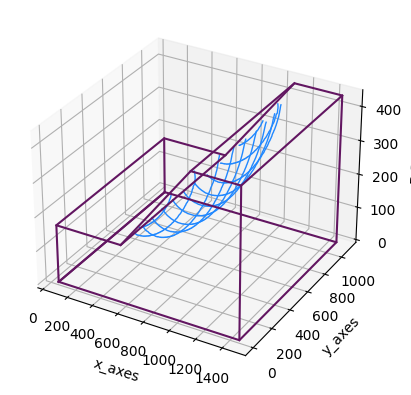

In [20]:
# 1 导入需要的库和定义画图需要的变量
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

z_str_of_current_in = np.array(["02.50", "05.00", "10.00", "15.00", "20.00", "25.00", "30.00", "35.00", "40.00", "45.00", "47.50"])
z_float_of_current_in = np.array([float(str_i) for str_i in z_str_of_current_in])
image_path = "program_process_files"

p_A = [  63, 635, 0]
p_B = [1470, 635, 0]
p_C = [1470, 196, 0]
p_D = [1106, 196, 0]
p_E = [ 570, 465, 0]
p_F = [  63, 465, 0]

k = 21.93548

z_ = 50 * k

p_A_z = [  63, 635, z_]
p_B_z = [1470, 635, z_]
p_C_z = [1470, 196, z_]
p_D_z = [1106, 196, z_]
p_E_z = [ 570, 465, z_]
p_F_z = [  63, 465, z_]

x_array_array = [0 for i in range(len(z_str_of_current_in))]
y_array_array = [0 for i in range(len(z_str_of_current_in))]
z_array_array = [0 for i in range(len(z_str_of_current_in))]

for i in range(len(z_str_of_current_in)):
    x_array_array[i] = np.loadtxt(image_path + "\\x_array_" + z_str_of_current_in[i] + ".txt", dtype=float)
    y_array_array[i] = np.loadtxt(image_path + "\\y_array_" + z_str_of_current_in[i] + ".txt", dtype=float)
    z_array_array[i] = np.loadtxt(image_path + "\\z_array_" + z_str_of_current_in[i] + ".txt", dtype=float)
# 2 开始绘图
#定义坐标轴
fig = plt.figure()
ax1 = plt.axes(projection='3d')
# 设置坐标轴标签
ax1.set_xlabel("x_axes")
ax1.set_ylabel("y_axes")
ax1.set_zlabel("z_axes")


# 先画边坡
slope_zero_x_array = np.array([p_A[0], p_B[0], p_C[0], p_D[0], p_E[0], p_F[0], p_A[0]])
slope_zero_y_array = np.array([p_A[1], p_B[1], p_C[1], p_D[1], p_E[1], p_F[1], p_A[1]])
slope_zero_z_array = np.array([p_A[2], p_B[2], p_C[2], p_D[2], p_E[2], p_F[2], p_A[2]])

slope_50_x_array = np.array([p_A_z[0], p_B_z[0], p_C_z[0], p_D_z[0], p_E_z[0], p_F_z[0], p_A_z[0]])
slope_50_y_array = np.array([p_A_z[1], p_B_z[1], p_C_z[1], p_D_z[1], p_E_z[1], p_F_z[1], p_A_z[1]])
slope_50_z_array = np.array([p_A_z[2], p_B_z[2], p_C_z[2], p_D_z[2], p_E_z[2], p_F_z[2], p_A_z[2]])

# 按正常的视图设置坐标
max_y_ = max(slope_zero_y_array)
slope_zero_y_array = max_y_ - slope_zero_y_array
slope_50_y_array = max_y_ - slope_50_y_array
slope_zero_y_array, slope_zero_z_array  = slope_zero_z_array, slope_zero_y_array
slope_50_y_array, slope_50_z_array = slope_50_z_array, slope_50_y_array

ax1.plot(slope_zero_x_array, slope_zero_y_array, slope_zero_z_array, linewidth=1.5, color="#621661", zorder=2)
ax1.plot(slope_50_x_array, slope_50_y_array, slope_50_z_array, linewidth=1.5, color="#621661", zorder=2)

for i in range(len(slope_50_x_array)):
    x_array_ = np.array([slope_zero_x_array[i], slope_50_x_array[i]])
    y_array_ = np.array([slope_zero_y_array[i], slope_50_y_array[i]])
    z_array_ = np.array([slope_zero_z_array[i], slope_50_z_array[i]])

    ax1.plot(x_array_, y_array_, z_array_, linewidth=1.5, color="#621661", zorder=2)

# 绘制滑动面
for i in range(len(x_array_array)):
    temp_y = y_array_array[i]
    temp_z = z_array_array[i]
    
    temp_y = max_y_ - temp_y
    temp_y, temp_z = temp_z, temp_y

    ax1.plot(x_array_array[i], temp_y, temp_z, linewidth=1, color="#2188ff", zorder=1)

plt.show()

### 4.4 绘制切片示意图 / Draw a schematic diagram of the slice

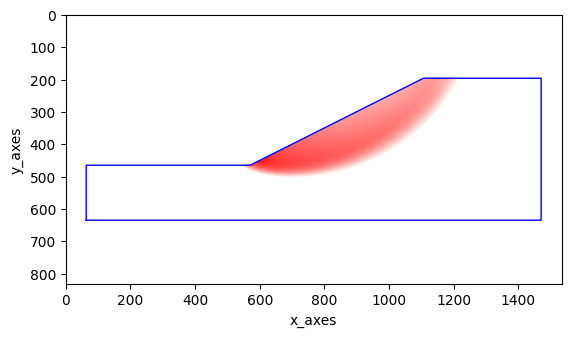

In [21]:
# 开始绘图
# 定义坐标轴
fig = plt.figure()
ax1 = plt.axes()
# 设置坐标轴标签
ax1.set_xlabel("x_axes")
ax1.set_ylabel("y_axes")


# 先画边坡
slope_zero_x_array = np.array([p_A[0], p_B[0], p_C[0], p_D[0], p_E[0], p_F[0], p_A[0]])
slope_zero_y_array = np.array([p_A[1], p_B[1], p_C[1], p_D[1], p_E[1], p_F[1], p_A[1]])

image_file = image_path + r"\Slice_slide_15.00.png"

img = Image.open(image_file)
plt.imshow(img)
plt.plot(slope_zero_x_array, slope_zero_y_array, linewidth=1, color="blue")
plt.savefig(image_path + "\\cut_show.pdf", format="pdf", dpi=1200, pad_inches=0)

### 4.5 绘制该切片上的滑面 / Draw the sliding surface on the slice

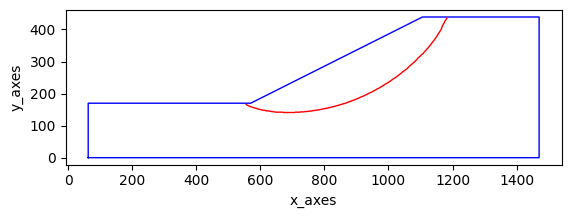

In [22]:
# 开始绘图
# 定义坐标轴
fig = plt.figure()
ax1 = plt.axes()
# 设置坐标轴标签
ax1.set_xlabel("x_axes")
ax1.set_ylabel("y_axes")
ax1.set_aspect("equal")

# 先画边坡
slope_zero_x_array = np.array([p_A[0], p_B[0], p_C[0], p_D[0], p_E[0], p_F[0], p_A[0]])
slope_zero_y_array = np.array([p_A[1], p_B[1], p_C[1], p_D[1], p_E[1], p_F[1], p_A[1]])
max_y_ = max(slope_zero_y_array)
slope_zero_y_array = max_y_ - slope_zero_y_array

plt.plot(slope_zero_x_array, slope_zero_y_array, linewidth=1, color="blue")

x_array_array_15 = np.loadtxt(image_path + "\\x_array_" + "15.00" + ".txt", dtype=float)
y_array_array_15 = np.loadtxt(image_path + "\\y_array_" + "15.00" + ".txt", dtype=float)
y_array_array_15 = max_y_ - y_array_array_15

plt.plot(x_array_array_15, y_array_array_15, linewidth=1, color="red")
plt.savefig(image_path + "\\sliding_15.00.pdf", format="pdf", dpi=1200, pad_inches=0)

# END